In [1]:
import os as os


import pandas as pd
from bigdatavqa.coreset import Coreset
from bigdatavqa.gmm import (
    GMMClusteringClassicalGMM,
    GMMClusteringMaxCut,
    GMMClusteringVQA,
    GMMClusteringRandom,
)
from bigdatavqa.vqe_utils import get_VQE_circuit, create_GMM_hamiltonian
from bigdatavqa.optimizer import get_optimizer_for_VQE
import cudaq
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
qubits = 10
coreset_size = qubits
circuit_depth = 1
max_shots = 1000
max_iterations = 100
number_of_experiment_runs = 5
number_of_corsets_to_evaluate = 15
number_of_centroid_evaluation = 20

## Data

Using BFL2 method to generate coresets


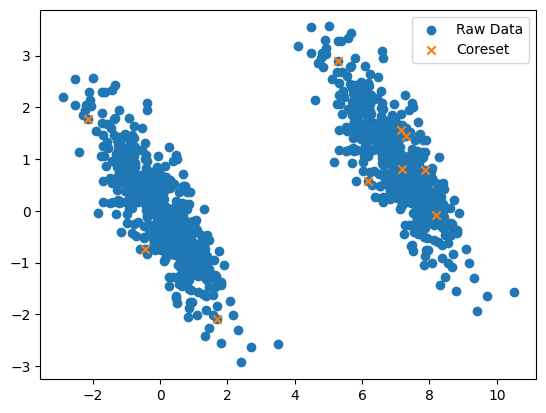

In [3]:
raw_data = Coreset.create_dataset(1000)
raw_data_df = pd.DataFrame(raw_data, columns=list("XY"))

coreset = Coreset(
    raw_data=raw_data,
    number_of_sampling_for_centroids=10,
    coreset_size=coreset_size,
    number_of_coresets_to_evaluate=4,
    coreset_method="BFL2",
)

coreset_vectors, coreset_weights = coreset.get_best_coresets()

coreset_df = pd.DataFrame(coreset_vectors, columns=list("XY"))
coreset_df["weights"] = coreset_weights
coreset_df["Name"] = [chr(i + 65) for i in coreset_df.index]

plt.scatter(raw_data_df["X"], raw_data_df["Y"], label="Raw Data")
plt.scatter(coreset_df["X"], coreset_df["Y"], label="Coreset", marker="x")
plt.legend()
plt.show()

## Clustering using VQE GMM

Cluster cost : 52.13555285121534
Labels: [1, 0, 1, 0, 1, 0, 0, 0, 1, 1]


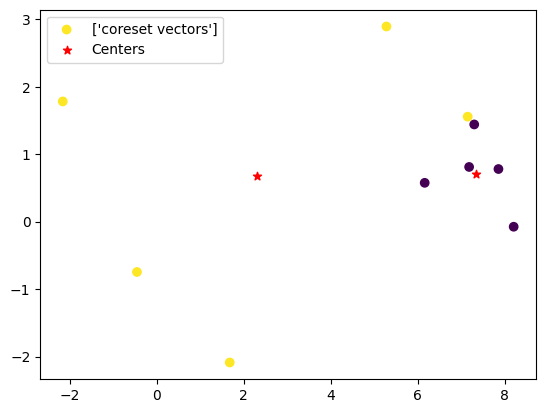

In [10]:
optimizer = cudaq.optimizers.COBYLA()

GMM_VQE = GMMClusteringVQA(
    qubits=qubits,
    create_circuit=get_VQE_circuit,
    circuit_depth=circuit_depth,
    optimizer_function=get_optimizer_for_VQE,
    optimizer=optimizer,
    create_Hamiltonian=create_GMM_hamiltonian,
    max_iterations=max_iterations,
    max_shots=max_shots,
)

GMM_VQE.fit(coreset_df=coreset_df, vector_columns=["X", "Y"], weight_columns="weights")


print(f"Cluster cost : {GMM_VQE.cost}")
print(f"Labels: {GMM_VQE.labels}")

coreset_df["k"] = GMM_VQE.labels

plt.scatter(
    coreset_df["X"], coreset_df["Y"], c=coreset_df["k"], label=["coreset vectors"], cmap="viridis"
)
plt.scatter(
    GMM_VQE.cluster_centers[:, 0],
    GMM_VQE.cluster_centers[:, 1],
    marker="*",
    color="r",
    label="Centers",
)
plt.legend()
plt.show()

### Visualizing the clustering on the entire data

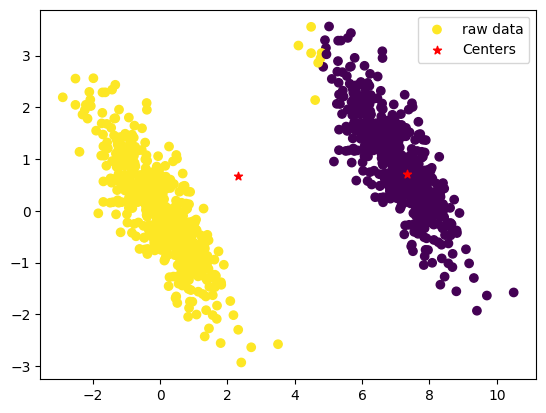

In [11]:
cost, raw_data_df["k"] = GMM_VQE.get_centroids_based_cost(raw_data, GMM_VQE.cluster_centers)

plt.scatter(
    raw_data_df["X"], raw_data_df["Y"], c=raw_data_df["k"], label="raw data", cmap="viridis"
)
plt.scatter(
    GMM_VQE.cluster_centers[:, 0],
    GMM_VQE.cluster_centers[:, 1],
    marker="*",
    color="r",
    label="Centers",
)
plt.legend()
plt.show()

## Clustering uising classical GMM

Cluster cost : 26.474421752148327
Labels: [1 0 1 0 1 0 0 0 0 0]


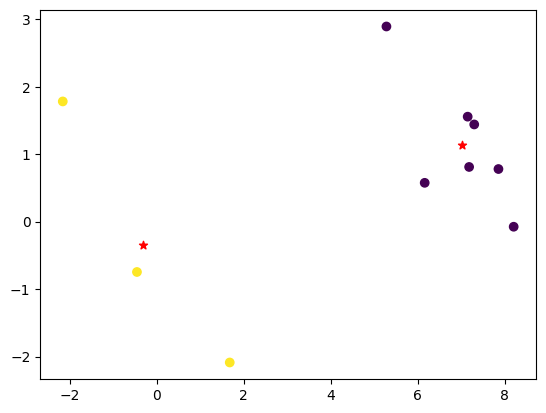

In [12]:
GMM_Classical = GMMClusteringClassicalGMM(normalize_vectors=False)

GMM_Classical.fit(coreset_df=coreset_df, vector_columns=["X", "Y"], weight_columns="weights")

print(f"Cluster cost : {GMM_Classical.cost}")
print(f"Labels: {GMM_Classical.labels}")

coreset_df["k"] = GMM_Classical.labels

plt.scatter(coreset_df["X"], coreset_df["Y"], c=coreset_df["k"], label="Coreset", cmap="viridis")
plt.scatter(
    GMM_Classical.cluster_centers[:, 0], GMM_Classical.cluster_centers[:, 1], marker="*", color="r"
)
plt.show()

## Clustering using random bitstring

Cluster cost : 84.22021229367878
Labels: [1, 0, 1, 0, 0, 1, 0, 1, 1, 0]


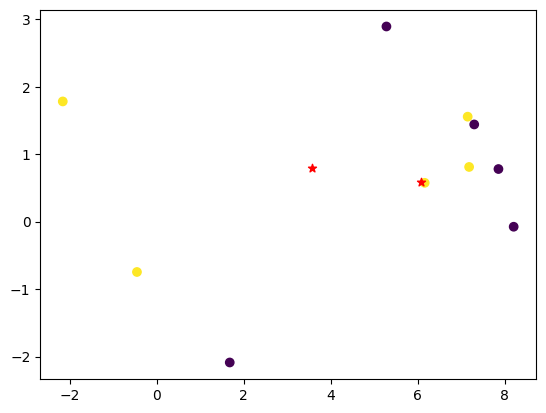

In [13]:
GMM_random = GMMClusteringRandom(normalize_vectors=True)

GMM_random.fit(coreset_df=coreset_df, vector_columns=["X", "Y"], weight_columns="weights")


print(f"Cluster cost : {GMM_random.cost}")
print(f"Labels: {GMM_random.labels}")

coreset_df["k"] = GMM_random.labels

plt.scatter(coreset_df["X"], coreset_df["Y"], c=coreset_df["k"], label="Coreset", cmap="viridis")
plt.scatter(
    GMM_random.cluster_centers[:, 0], GMM_random.cluster_centers[:, 1], marker="*", color="r"
)
plt.show()

## Clustering using MaxCut

100%|██████████| 1022/1022 [00:03<00:00, 265.87it/s]


Cluster cost : 26.474421752148324
Labels: [0, 1, 0, 1, 0, 1, 1, 1, 1, 1]


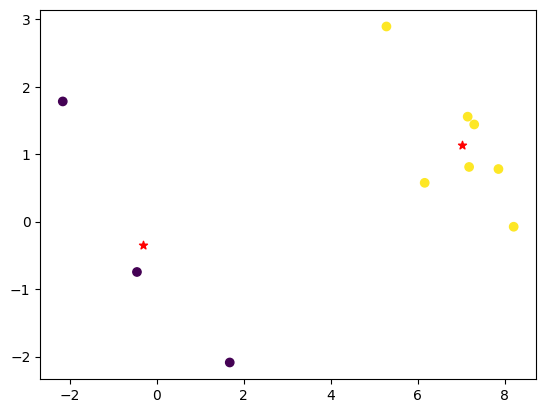

In [15]:
GMM_MaxCut = GMMClusteringMaxCut(normalize_vectors=True)

GMM_MaxCut.fit(coreset_df=coreset_df, vector_columns=["X", "Y"], weight_columns="weights")

print(f"Cluster cost : {GMM_MaxCut.cost}")
print(f"Labels: {GMM_MaxCut.labels}")

coreset_df["k"] = GMM_MaxCut.labels

plt.scatter(coreset_df["X"], coreset_df["Y"], c=coreset_df["k"], label="Coreset", cmap="viridis")
plt.scatter(
    GMM_MaxCut.cluster_centers[:, 0], GMM_MaxCut.cluster_centers[:, 1], marker="*", color="r"
)
plt.show()

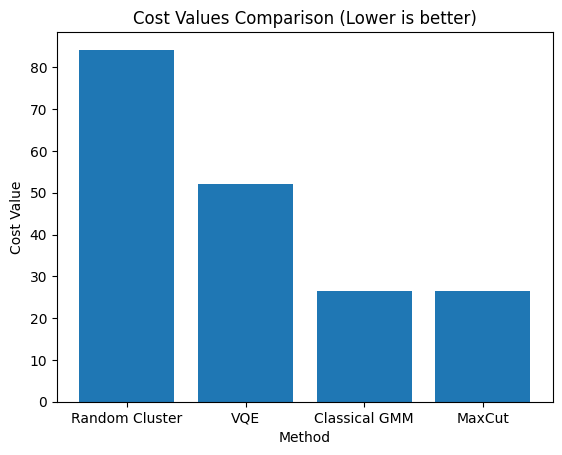

In [16]:
cost_values = [GMM_random.cost, GMM_VQE.cost, GMM_Classical.cost, GMM_MaxCut.cost]


labels = ["Random Cluster", "VQE", "Classical GMM", "MaxCut"]


plt.bar(labels, cost_values)


plt.xlabel("Method")
plt.ylabel("Cost Value")
plt.title("Cost Values Comparison (Lower is better)")


plt.show()